[INFO] Opening /Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/preprocessed/transfer_learning/avh15c1/avh15c1_lai.nc
[INFO] Plotting variable: avh15c1_lai


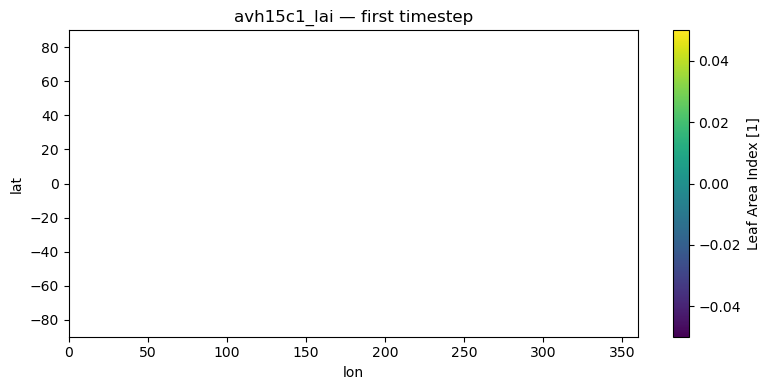

In [4]:
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------------------------------------------------------------
# Hardcoded input/output
# ---------------------------------------------------------------------
in_path = Path("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/preprocessed/transfer_learning/avh15c1/avh15c1_lai.nc")

# ---------------------------------------------------------------------
# Open dataset and inspect
# ---------------------------------------------------------------------
print(f"[INFO] Opening {in_path}")
ds = xr.open_dataset(in_path)

da = ds['avh15c1_lai']
print(f"[INFO] Plotting variable: {var_name}")

# ---------------------------------------------------------------------
# Extract first timestep
# ---------------------------------------------------------------------
first_slice = da.isel(time=0)

# ---------------------------------------------------------------------
# Plot
# ---------------------------------------------------------------------
plt.figure(figsize=(8, 4))
first_slice.plot(cmap="viridis")
plt.title(f"{var_name} — first timestep")
plt.tight_layout()

plt.show()

In [6]:
#!/usr/bin/env python3
import xarray as xr
import numpy as np
from pathlib import Path

in_path = Path("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/preprocessed/transfer_learning/avh15c1/avh15c1_lai.nc")

print(f"[INFO] Opening {in_path}")
ds = xr.open_dataset(in_path)
da = ds["avh15c1_lai"]

# Flatten data to 1D NumPy array
arr = da.values.flatten()

# Mask out NaNs and zeros
mask = np.isfinite(arr) & (arr != 0)
valid = arr[mask]

# Print first few valid entries
print(f"[INFO] Total valid values: {valid.size}")
if valid.size == 0:
    print("[WARN] No non-NaN, non-zero values found.")
else:
    print("[INFO] First 10 non-NaN, non-zero values:")
    print(valid[:10])

[INFO] Opening /Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/preprocessed/transfer_learning/avh15c1/avh15c1_lai.nc
[INFO] Total valid values: 24860425
[INFO] First 10 non-NaN, non-zero values:
[0.217      0.00657143 0.75266667 0.669      0.0235     0.0015
 0.1925     0.186      0.0185     0.1135    ]


[INFO] Opening /Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/preprocessed/transfer_learning/avh15c1/avh15c1_lai.nc
[INFO] First non-zero timestep index: 6
[INFO] Slice stats: min=0.0 max=6.007000000000001 count>0=63467


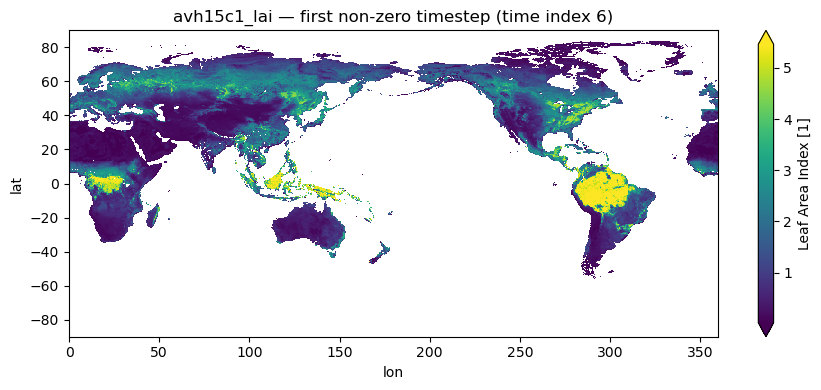

In [7]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

in_path = Path("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/preprocessed/transfer_learning/avh15c1/avh15c1_lai.nc")
var_name = "avh15c1_lai"

print(f"[INFO] Opening {in_path}")
ds = xr.open_dataset(in_path)
da = ds[var_name]

# Ensure fill values are masked out
da = da.where(da != -999)

# Find first timestep that has any finite & >0 value
has_signal = (np.isfinite(da) & (da > 0)).any(dim=("lat", "lon"))
if not bool(has_signal.any()):
    raise SystemExit("[WARN] No non-NaN, non-zero values at any time step.")

t_idx = int(has_signal.argmax().values)
print(f"[INFO] First non-zero timestep index: {t_idx}")

sl = da.isel(time=t_idx)

# Basic stats for sanity
print("[INFO] Slice stats:",
      f"min={float(sl.where(np.isfinite(sl)).min())}",
      f"max={float(sl.where(np.isfinite(sl)).max())}",
      f"count>0={(sl>0).sum().item()}")

# Plot (robust handles outliers / flat ranges better)
plt.figure(figsize=(9,4))
sl.plot(robust=True, cmap="viridis")
plt.title(f"{var_name} — first non-zero timestep (time index {t_idx})")
plt.tight_layout()
plt.show()


In [10]:
import xarray as xr
import numpy as np
from pathlib import Path

in_path = Path("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/preprocessed/transfer_learning/avh15c1/avh15c1_lai.nc")
var_name = "avh15c1_lai"

# Open + CF decode (calendar="noleap" -> cftime objects)
ds = xr.open_dataset(in_path)
ds_dec = xr.decode_cf(ds)  # respects units="days since 1901-01-01", calendar="noleap"

# Work on the variable and mask fill values
da = ds_dec[var_name].where(ds_dec[var_name] != -999)

# For each month (time step), test: all finite values == 0 (ignore NaNs)
finite_any = np.isfinite(da).any(dim=("lat", "lon"))
all_zero_or_nan = ((da == 0) | ~np.isfinite(da)).all(dim=("lat", "lon"))
fully_zero_month = all_zero_or_nan & finite_any

# Collect months as YYYY-MM strings
times = ds_dec["time"].values
months_zero = [f"{t.year:04d}-{t.month:02d}" for t, flag in zip(times, fully_zero_month.values) if flag]

print(f"[INFO] Found {len(months_zero)} fully-zero months.")
for m in months_zero:
    print(m)

[INFO] Found 0 fully-zero months.


In [11]:
import xarray as xr
import numpy as np
from pathlib import Path

in_path = Path("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/preprocessed/transfer_learning/avh15c1/avh15c1_lai.nc")
var = "avh15c1_lai"

ds = xr.decode_cf(xr.open_dataset(in_path))
da = ds[var].where(ds[var] != -999)  # mask fill

# Per-month reductions
finite_any = np.isfinite(da).any(dim=("lat","lon"))
all_nan    = ~finite_any
all_zero   = finite_any & (da.fillna(0).sum(dim=("lat","lon")) == 0)
has_pos    = (da > 0).any(dim=("lat","lon"))  # sanity

times = ds["time"].values

all_nan_months  = [f"{t.year:04d}-{t.month:02d}" for t, f in zip(times, all_nan.values)  if f]
all_zero_months = [f"{t.year:04d}-{t.month:02d}" for t, f in zip(times, all_zero.values) if f]
pos_months      = [f"{t.year:04d}-{t.month:02d}" for t, f in zip(times, has_pos.values)  if f]

print(f"[INFO] all-NaN months:  {len(all_nan_months)}")
print(", ".join(all_nan_months[:24]), "..." if len(all_nan_months)>24 else "")
print(f"[INFO] fully-zero months (finite & ==0): {len(all_zero_months)}")
print(", ".join(all_zero_months[:24]), "..." if len(all_zero_months)>24 else "")
print(f"[INFO] months with any >0: {len(pos_months)}")
print(", ".join(pos_months[:24]), "..." if len(pos_months)>24 else "")

# First month with any >0 value (matches your earlier 6)
first_pos_idx = int(np.argmax(has_pos.values))
print(f"[INFO] First month with >0 anywhere: index={first_pos_idx}, date={times[first_pos_idx].year:04d}-{times[first_pos_idx].month:02d}")

[INFO] all-NaN months:  13
1981-01, 1981-02, 1981-03, 1981-04, 1981-05, 1981-06, 1994-10, 1994-11, 1994-12, 2019-09, 2019-10, 2019-11, 2019-12 
[INFO] fully-zero months (finite & ==0): 0
 
[INFO] months with any >0: 455
1981-07, 1981-08, 1981-09, 1981-10, 1981-11, 1981-12, 1982-01, 1982-02, 1982-03, 1982-04, 1982-05, 1982-06, 1982-07, 1982-08, 1982-09, 1982-10, 1982-11, 1982-12, 1983-01, 1983-02, 1983-03, 1983-04, 1983-05, 1983-06 ...
[INFO] First month with >0 anywhere: index=6, date=1981-07


In [12]:
import xarray as xr
from pathlib import Path

in_path = Path("/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/data/preprocessed/transfer_learning/avh15c1/avh15c1_lai.nc")

# Decode CF-compliant time axis (days since 1901-01-01, noleap calendar)
ds = xr.decode_cf(xr.open_dataset(in_path))

# Extract the decoded time values
times = ds["time"].values

# Print count and all formatted dates
print(f"[INFO] Found {len(times)} time steps:")
for t in times:
    print(t)

[INFO] Found 468 time steps:
1981-01-01 00:00:00
1981-02-01 00:00:00
1981-03-01 00:00:00
1981-04-01 00:00:00
1981-05-01 00:00:00
1981-06-01 00:00:00
1981-07-01 00:00:00
1981-08-01 00:00:00
1981-09-01 00:00:00
1981-10-01 00:00:00
1981-11-01 00:00:00
1981-12-01 00:00:00
1982-01-01 00:00:00
1982-02-01 00:00:00
1982-03-01 00:00:00
1982-04-01 00:00:00
1982-05-01 00:00:00
1982-06-01 00:00:00
1982-07-01 00:00:00
1982-08-01 00:00:00
1982-09-01 00:00:00
1982-10-01 00:00:00
1982-11-01 00:00:00
1982-12-01 00:00:00
1983-01-01 00:00:00
1983-02-01 00:00:00
1983-03-01 00:00:00
1983-04-01 00:00:00
1983-05-01 00:00:00
1983-06-01 00:00:00
1983-07-01 00:00:00
1983-08-01 00:00:00
1983-09-01 00:00:00
1983-10-01 00:00:00
1983-11-01 00:00:00
1983-12-01 00:00:00
1984-01-01 00:00:00
1984-02-01 00:00:00
1984-03-01 00:00:00
1984-04-01 00:00:00
1984-05-01 00:00:00
1984-06-01 00:00:00
1984-07-01 00:00:00
1984-08-01 00:00:00
1984-09-01 00:00:00
1984-10-01 00:00:00
1984-11-01 00:00:00
1984-12-01 00:00:00
1985-01-01 

[INFO] Opening /Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/scripts/preprocessing/lai_obs/avh15c1/sanity_check/nan_mask/avh15c1_lai.nc
[INFO] Plotting variable: avh15c1_lai


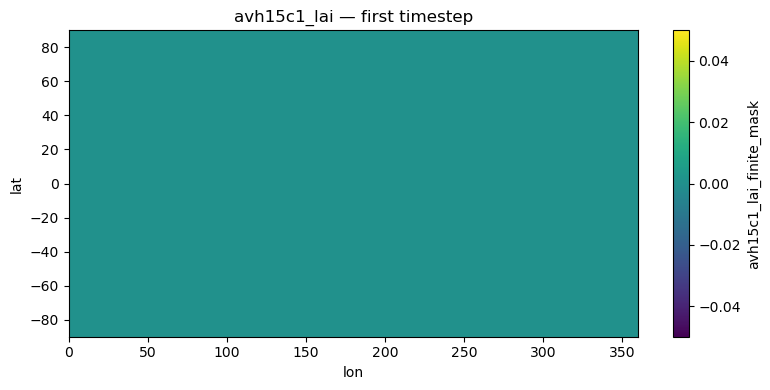

In [15]:
in_path = "/Net/Groups/BGI/people/ecathain/TRENDY_Emulator_Scripts/NewModel/scripts/preprocessing/lai_obs/avh15c1/sanity_check/nan_mask/avh15c1_lai.nc"

print(f"[INFO] Opening {in_path}")
ds = xr.open_dataset(in_path)

da = ds['avh15c1_lai_finite_mask']
print(f"[INFO] Plotting variable: {var_name}")

# ---------------------------------------------------------------------
# Extract first timestep
# ---------------------------------------------------------------------
first_slice = da.isel()

# ---------------------------------------------------------------------
# Plot
# ---------------------------------------------------------------------
plt.figure(figsize=(8, 4))
first_slice.plot(cmap="viridis")
plt.title(f"{var_name} — first timestep")
plt.tight_layout()

plt.show()